<a href="https://colab.research.google.com/github/vaishu2229/Travelling/blob/main/IDP_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def resize_with_aspect_ratio(image, target_size, padding_color=(0, 0, 0)):
    """
    Resize the image to the target size while maintaining aspect ratio.
    Adds padding to the image to fill up the remaining space.
    """
    h, w = image.shape[:2]
    target_w, target_h = target_size

    # Calculate aspect ratio
    aspect_ratio = w / h

    if aspect_ratio > target_w / target_h:
        # Width is the constraining factor, scale by width
        new_w = target_w
        new_h = int(new_w / aspect_ratio)
    else:
        # Height is the constraining factor, scale by height
        new_h = target_h
        new_w = int(new_h * aspect_ratio)

    # Resize the image while maintaining the aspect ratio
    resized_image = cv2.resize(image, (new_w, new_h))

    # Create a new image of the target size with the padding color
    padded_image = np.full((target_h, target_w, 3), padding_color, dtype=np.uint8)

    # Center the resized image within the new padded image
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    padded_image[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_image

    return padded_image

def preprocess_images(input_folder, output_folder, img_size=(224, 224), augment=False):
    """
    Preprocess images from the input folder and save them to the output folder.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    try:
        # Initialize data augmentation if specified
        if augment:
            datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )

        # Walk through all directories and subdirectories
        for root, dirs, files in os.walk(input_folder):
            for file_name in files:
                if file_name.endswith(('.jpg', '.jpeg', '.png')):
                    # Construct full file path
                    file_path = os.path.join(root, file_name)

                    # Load image
                    image = cv2.imread(file_path)

                    if image is None:
                        print(f"Error: Could not read image {file_name}. Skipping.")
                        continue

                    print(f"Processing: {file_name}")

                    # Step 1: Resize the image with aspect ratio preservation
                    resized_image = resize_with_aspect_ratio(image, img_size)

                    # Step 2: Normalize the image
                    normalized_image = resized_image / 255.0

                    # Step 3: Grayscale conversion
                    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

                    # Step 4: Binarization for OCR or specific tasks
                    _, binary_image = cv2.threshold(grayscale_image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

                    # Step 5: Edge detection
                    edges = cv2.Canny(grayscale_image, 100, 200)

                    # Create subfolder structure in the output folder to match input folder structure
                    relative_path = os.path.relpath(file_path, input_folder)
                    output_subfolder = os.path.join(output_folder, os.path.dirname(relative_path))
                    if not os.path.exists(output_subfolder):
                        os.makedirs(output_subfolder)

                    # Save processed images
                    output_file_path = os.path.join(output_subfolder, f"resized_{file_name}")
                    cv2.imwrite(output_file_path, (normalized_image * 255).astype(np.uint8))
                    print(f"Processed and saved: {output_file_path}")

                    # Saving grayscale, binary, or edge images can be optional, depending on task requirements
                    output_grayscale_path = os.path.join(output_subfolder, f"grayscale_{file_name}")
                    cv2.imwrite(output_grayscale_path, grayscale_image)

                    output_binary_path = os.path.join(output_subfolder, f"binary_{file_name}")
                    cv2.imwrite(output_binary_path, binary_image)

                    output_edges_path = os.path.join(output_subfolder, f"edges_{file_name}")
                    cv2.imwrite(output_edges_path, edges)

                    # Step 6: Data Augmentation (only if augment=True)
                    if augment:
                        augmented = np.expand_dims(resized_image, 0)  # Keras requires 4D input for ImageDataGenerator
                        aug_iter = datagen.flow(augmented, batch_size=1)
                        for i in range(3):  # Generate 3 augmented images for each original image
                            augmented_image = next(aug_iter)[0].astype(np.uint8)
                            output_aug_path = os.path.join(output_folder, f"augmented_{i}_{file_name}")
                            cv2.imwrite(output_aug_path, augmented_image)
                            print(f"Augmented and saved: {output_aug_path}")

    except FileNotFoundError:
        print(f"Error: Folder not found at {input_folder}")

if __name__ == '__main__':
    input_folder = '/content/drive/MyDrive/Test'  # Replace with your actual dataset folder path
    extracted_folder = 'extracted_test'
    output_folder = 'preprocessed_test'  # Folder where preprocessed images will be saved
    img_size = (224, 224)  # Target size for CNN input, can change based on your model requirement
    augment = True  # Set to True if you want to perform data augmentation

    # Step 1: Preprocess the images in the input folder
    preprocess_images(input_folder, output_folder, img_size=img_size, augment=augment)

    # Debugging: Check if files are being saved in the output folder
    if os.path.exists(output_folder):
        print("Processed images folder contents:", os.listdir(output_folder))
    else:
        print(f"Error: Output folder {output_folder} not found.")


Processing: ISIC_0024370.jpg
Processed and saved: preprocessed_test/vascular lesion/resized_ISIC_0024370.jpg
Augmented and saved: preprocessed_test/augmented_0_ISIC_0024370.jpg
Augmented and saved: preprocessed_test/augmented_1_ISIC_0024370.jpg
Augmented and saved: preprocessed_test/augmented_2_ISIC_0024370.jpg
Processing: ISIC_0024402.jpg
Processed and saved: preprocessed_test/vascular lesion/resized_ISIC_0024402.jpg
Augmented and saved: preprocessed_test/augmented_0_ISIC_0024402.jpg
Augmented and saved: preprocessed_test/augmented_1_ISIC_0024402.jpg
Augmented and saved: preprocessed_test/augmented_2_ISIC_0024402.jpg
Processing: ISIC_0024375.jpg
Processed and saved: preprocessed_test/vascular lesion/resized_ISIC_0024375.jpg
Augmented and saved: preprocessed_test/augmented_0_ISIC_0024375.jpg
Augmented and saved: preprocessed_test/augmented_1_ISIC_0024375.jpg
Augmented and saved: preprocessed_test/augmented_2_ISIC_0024375.jpg
Processing: ISIC_0024331.jpg
Processed and saved: preprocesse

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def resize_with_aspect_ratio(image, target_size, padding_color=(0, 0, 0)):
    """
    Resize the image to the target size while maintaining aspect ratio.
    Adds padding to the image to fill up the remaining space.
    """
    h, w = image.shape[:2]
    target_w, target_h = target_size

    # Calculate aspect ratio
    aspect_ratio = w / h

    if aspect_ratio > target_w / target_h:
        # Width is the constraining factor, scale by width
        new_w = target_w
        new_h = int(new_w / aspect_ratio)
    else:
        # Height is the constraining factor, scale by height
        new_h = target_h
        new_w = int(new_h * aspect_ratio)

    # Resize the image while maintaining the aspect ratio
    resized_image = cv2.resize(image, (new_w, new_h))

    # Create a new image of the target size with the padding color
    padded_image = np.full((target_h, target_w, 3), padding_color, dtype=np.uint8)

    # Center the resized image within the new padded image
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    padded_image[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_image

    return padded_image

def preprocess_images(input_folder, output_folder, img_size=(224, 224), augment=False):
    """
    Preprocess images from the input folder and save them to the output folder.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    try:
        # Initialize data augmentation if specified
        if augment:
            datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )

        # Walk through all directories and subdirectories
        for root, dirs, files in os.walk(input_folder):
            for file_name in files:
                if file_name.endswith(('.jpg', '.jpeg', '.png')):
                    # Construct full file path
                    file_path = os.path.join(root, file_name)

                    # Load image
                    image = cv2.imread(file_path)

                    if image is None:
                        print(f"Error: Could not read image {file_name}. Skipping.")
                        continue

                    print(f"Processing: {file_name}")

                    # Step 1: Resize the image with aspect ratio preservation
                    resized_image = resize_with_aspect_ratio(image, img_size)

                    # Step 2: Normalize the image
                    normalized_image = resized_image / 255.0

                    # Step 3: Grayscale conversion
                    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

                    # Step 4: Binarization for OCR or specific tasks
                    _, binary_image = cv2.threshold(grayscale_image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

                    # Step 5: Edge detection
                    edges = cv2.Canny(grayscale_image, 100, 200)

                    # Create subfolder structure in the output folder to match input folder structure
                    relative_path = os.path.relpath(file_path, input_folder)
                    output_subfolder = os.path.join(output_folder, os.path.dirname(relative_path))
                    if not os.path.exists(output_subfolder):
                        os.makedirs(output_subfolder)

                    # Save processed images
                    output_file_path = os.path.join(output_subfolder, f"resized_{file_name}")
                    cv2.imwrite(output_file_path, (normalized_image * 255).astype(np.uint8))
                    print(f"Processed and saved: {output_file_path}")

                    # Saving grayscale, binary, or edge images can be optional, depending on task requirements
                    output_grayscale_path = os.path.join(output_subfolder, f"grayscale_{file_name}")
                    cv2.imwrite(output_grayscale_path, grayscale_image)

                    output_binary_path = os.path.join(output_subfolder, f"binary_{file_name}")
                    cv2.imwrite(output_binary_path, binary_image)

                    output_edges_path = os.path.join(output_subfolder, f"edges_{file_name}")
                    cv2.imwrite(output_edges_path, edges)

                    # Step 6: Data Augmentation (only if augment=True)
                    if augment:
                        augmented = np.expand_dims(resized_image, 0)  # Keras requires 4D input for ImageDataGenerator
                        aug_iter = datagen.flow(augmented, batch_size=1)
                        for i in range(3):  # Generate 3 augmented images for each original image
                            augmented_image = next(aug_iter)[0].astype(np.uint8)
                            output_aug_path = os.path.join(output_folder, f"augmented_{i}_{file_name}")
                            cv2.imwrite(output_aug_path, augmented_image)
                            print(f"Augmented and saved: {output_aug_path}")

    except FileNotFoundError:
        print(f"Error: Folder not found at {input_folder}")

if __name__ == '__main__':
    input_folder = '/content/drive/MyDrive/Train'  # Replace with your actual dataset folder path
    extracted_folder = 'extracted_train'
    output_folder = 'preprocessed_train'  # Folder where preprocessed images will be saved
    img_size = (224, 224)  # Target size for CNN input, can change based on your model requirement
    augment = True  # Set to True if you want to perform data augmentation

    # Step 1: Preprocess the images in the input folder
    preprocess_images(input_folder, output_folder, img_size=img_size, augment=augment)

    # Debugging: Check if files are being saved in the output folder
    if os.path.exists(output_folder):
        print("Processed images folder contents:", os.listdir(output_folder))
    else:
        print(f"Error: Output folder {output_folder} not found.")


Streaming output truncated to the last 5000 lines.
Processed and saved: preprocessed_train/pigmented benign keratosis/resized_ISIC_0025819.jpg
Augmented and saved: preprocessed_train/augmented_0_ISIC_0025819.jpg
Augmented and saved: preprocessed_train/augmented_1_ISIC_0025819.jpg
Augmented and saved: preprocessed_train/augmented_2_ISIC_0025819.jpg
Processing: ISIC_0025623.jpg
Processed and saved: preprocessed_train/pigmented benign keratosis/resized_ISIC_0025623.jpg
Augmented and saved: preprocessed_train/augmented_0_ISIC_0025623.jpg
Augmented and saved: preprocessed_train/augmented_1_ISIC_0025623.jpg
Augmented and saved: preprocessed_train/augmented_2_ISIC_0025623.jpg
Processing: ISIC_0025510.jpg
Processed and saved: preprocessed_train/pigmented benign keratosis/resized_ISIC_0025510.jpg
Augmented and saved: preprocessed_train/augmented_0_ISIC_0025510.jpg
Augmented and saved: preprocessed_train/augmented_1_ISIC_0025510.jpg
Augmented and saved: preprocessed_train/augmented_2_ISIC_002551

In [ ]:
import os
import cv2
import numpy as np
import math
from skimage.feature import graycomatrix, graycoprops

# Function to calculate asymmetry index
def calculate_asymmetry(binary_image):
    h, w = binary_image.shape
    left_half = binary_image[:, :w // 2]
    right_half = binary_image[:, w // 2:]

    # Flip right half horizontally
    right_half_flipped = cv2.flip(right_half, 1)

    # If the halves are not the same width, pad the smaller one
    if left_half.shape != right_half_flipped.shape:
        if left_half.shape[1] < right_half_flipped.shape[1]:
            pad_width = right_half_flipped.shape[1] - left_half.shape[1]
            left_half = np.pad(left_half, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
        else:
            pad_width = left_half.shape[1] - right_half_flipped.shape[1]
            right_half_flipped = np.pad(right_half_flipped, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)

    # Calculate the difference and asymmetry index
    difference = cv2.absdiff(left_half, right_half_flipped)
    asymmetry_index = np.sum(difference) / np.sum(binary_image)
    return asymmetry_index

# Function to calculate diameter of the lesion
def calculate_diameter(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        diameter = max(w, h)
        return diameter
    return 0

# Function to calculate border irregularity (perimeter^2 / area)
def calculate_border_irregularity(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        perimeter = cv2.arcLength(largest_contour, True)
        area = cv2.contourArea(largest_contour)
        if area == 0:
            return 0
        irregularity = (perimeter ** 2) / (4 * math.pi * area)
        return irregularity
    return 0

# Function to calculate mean color channels
def calculate_mean_color(image):
    mean_color = cv2.mean(image)[:3]  # BGR channels
    return mean_color

# Function to calculate texture features from co-occurrence matrix
def calculate_texture_features(gray_image):
    glcm = graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    texture_features = {
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'entropy': -np.sum(glcm * np.log2(glcm + (glcm == 0))),  # entropy from GLCM
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'contrast': graycoprops(glcm, 'contrast')[0, 0]
    }
    return texture_features

# Main function to extract features from an image
def extract_features(image_path):
    # Read and preprocess the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Error: Could not load {image_path}")
        return None

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Otsu's thresholding for segmentation
    _, binary_image = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Calculate features
    asymmetry_index = calculate_asymmetry(binary_image)
    diameter = calculate_diameter(binary_image)
    border_irregularity = calculate_border_irregularity(binary_image)
    mean_color = calculate_mean_color(image)
    texture_features = calculate_texture_features(gray)

    # Compile all features
    features = {
        'asymmetry_index': asymmetry_index,
        'diameter': diameter,
        'border_irregularity': border_irregularity,
        'mean_color': mean_color,
        'texture_features': texture_features
    }
    return features

# Function to process all images in a folder
def process_folder(input_folder):
    features_list = []
    for root, _, files in os.walk(input_folder):
        for file_name in files:
            if file_name.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file_name)
                print(f"Processing: {file_name}")
                features = extract_features(image_path)
                if features:
                    features_list.append({file_name: features})
    return features_list

# Path to the folder containing images
input_folder = '/content/drive/MyDrive/Test'  # Folder containing the extracted images from the ZIP

# Extract features for all images in the folder
features_data = process_folder(input_folder)

# Display the extracted features for each image
for feature_info in features_data:
    print(feature_info)


Processing: ISIC_0024370.jpg
Processing: ISIC_0024402.jpg
Processing: ISIC_0024375.jpg
Processing: ISIC_0024331.jpg
Processing: ISIC_0024345.jpg
Processing: ISIC_0024332.jpg
Processing: ISIC_0024457.jpg
Processing: ISIC_0024454.jpg
Processing: ISIC_0024403.jpg
Processing: ISIC_0024436.jpg
Processing: ISIC_0024452.jpg
Processing: ISIC_0024448.jpg
Processing: ISIC_0024360.jpg
Processing: ISIC_0024411.jpg
Processing: ISIC_0024472.jpg
Processing: ISIC_0024443.jpg
Processing: ISIC_0024431.jpg
Processing: ISIC_0024461.jpg
Processing: ISIC_0024432.jpg
Processing: ISIC_0024409.jpg
Processing: ISIC_0024338.jpg
Processing: ISIC_0024408.jpg
Processing: ISIC_0024371.jpg
Processing: ISIC_0024358.jpg
Processing: ISIC_0024336.jpg
Processing: ISIC_0024383.jpg
Processing: ISIC_0024412.jpg
Processing: ISIC_0024324.jpg
Processing: ISIC_0024422.jpg
Processing: ISIC_0024420.jpg
Processing: ISIC_0024312.jpg
Processing: ISIC_0024337.jpg
Processing: ISIC_0024426.jpg
Processing: ISIC_0024381.jpg
Processing: IS

In [ ]:
import os
import cv2
import numpy as np
import math
from skimage.feature import graycomatrix, graycoprops

# Function to calculate asymmetry index
def calculate_asymmetry(binary_image):
    h, w = binary_image.shape
    left_half = binary_image[:, :w // 2]
    right_half = binary_image[:, w // 2:]

    # Flip right half horizontally
    right_half_flipped = cv2.flip(right_half, 1)

    # If the halves are not the same width, pad the smaller one
    if left_half.shape != right_half_flipped.shape:
        if left_half.shape[1] < right_half_flipped.shape[1]:
            pad_width = right_half_flipped.shape[1] - left_half.shape[1]
            left_half = np.pad(left_half, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
        else:
            pad_width = left_half.shape[1] - right_half_flipped.shape[1]
            right_half_flipped = np.pad(right_half_flipped, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)

    # Calculate the difference and asymmetry index
    difference = cv2.absdiff(left_half, right_half_flipped)
    asymmetry_index = np.sum(difference) / np.sum(binary_image)
    return asymmetry_index

# Function to calculate diameter of the lesion
def calculate_diameter(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        diameter = max(w, h)
        return diameter
    return 0

# Function to calculate border irregularity (perimeter^2 / area)
def calculate_border_irregularity(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        perimeter = cv2.arcLength(largest_contour, True)
        area = cv2.contourArea(largest_contour)
        if area == 0:
            return 0
        irregularity = (perimeter ** 2) / (4 * math.pi * area)
        return irregularity
    return 0

# Function to calculate mean color channels
def calculate_mean_color(image):
    mean_color = cv2.mean(image)[:3]  # BGR channels
    return mean_color

# Function to calculate texture features from co-occurrence matrix
def calculate_texture_features(gray_image):
    glcm = graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    texture_features = {
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'entropy': -np.sum(glcm * np.log2(glcm + (glcm == 0))),  # entropy from GLCM
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'contrast': graycoprops(glcm, 'contrast')[0, 0]
    }
    return texture_features

# Main function to extract features from an image
def extract_features(image_path):
    # Read and preprocess the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Error: Could not load {image_path}")
        return None

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Otsu's thresholding for segmentation
    _, binary_image = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Calculate features
    asymmetry_index = calculate_asymmetry(binary_image)
    diameter = calculate_diameter(binary_image)
    border_irregularity = calculate_border_irregularity(binary_image)
    mean_color = calculate_mean_color(image)
    texture_features = calculate_texture_features(gray)

    # Compile all features
    features = {
        'asymmetry_index': asymmetry_index,
        'diameter': diameter,
        'border_irregularity': border_irregularity,
        'mean_color': mean_color,
        'texture_features': texture_features
    }
    return features

# Function to process all images in a folder
def process_folder(input_folder):
    features_list = []
    for root, _, files in os.walk(input_folder):
        for file_name in files:
            if file_name.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file_name)
                print(f"Processing: {file_name}")
                features = extract_features(image_path)
                if features:
                    features_list.append({file_name: features})
    return features_list

# Path to the folder containing images
input_folder = '/content/drive/MyDrive/Train'  # Folder containing the extracted images from the ZIP

# Extract features for all images in the folder
features_data = process_folder(input_folder)

# Display the extracted features for each image
for feature_info in features_data:
    print(feature_info)


Processing: ISIC_0024867.jpg
Processing: ISIC_0025677.jpg
Processing: ISIC_0025628.jpg
Processing: ISIC_0025612.jpg
Processing: ISIC_0025197.jpg
Processing: ISIC_0025599.jpg
Processing: ISIC_0025250.jpg
Processing: ISIC_0025606.jpg
Processing: ISIC_0025249.jpg
Processing: ISIC_0026092.jpg
Processing: ISIC_0024747.jpg
Processing: ISIC_0024669.jpg
Processing: ISIC_0024662.jpg
Processing: ISIC_0025924.jpg
Processing: ISIC_0025425.jpg
Processing: ISIC_0024904.jpg
Processing: ISIC_0025578.jpg
Processing: ISIC_0025873.jpg
Processing: ISIC_0026068.jpg
Processing: ISIC_0024475.jpg
Processing: ISIC_0024706.jpg
Processing: ISIC_0025707.jpg
Processing: ISIC_0025321.jpg
Processing: ISIC_0025680.jpg
Processing: ISIC_0025596.jpg
Processing: ISIC_0025807.jpg
Processing: ISIC_0025244.jpg
Processing: ISIC_0025452.jpg
Processing: ISIC_0026163.jpg
Processing: ISIC_0031276.jpg
Processing: ISIC_0032076.jpg
Processing: ISIC_0030956.jpg
Processing: ISIC_0027672.jpg
Processing: ISIC_0031217.jpg
Processing: IS

In [ ]:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to your train and test datasets
train_data_path = '/content/preprocessed_train'
test_data_path = '/content/preprocessed_test'

# Define image data generators
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    train_data_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_data_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Extract features and labels from the generators
X_train, y_train = [], []
for _ in range(len(train_generator)):
    X, y = next(train_generator)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = [], []
for _ in range(len(test_generator)):
    X, y = next(test_generator)
    X_test.append(X)
    y_test.append(y)

X_train = np.vstack(X_train)
y_train = np.vstack(y_train)
X_test = np.vstack(X_test)
y_test = np.vstack(y_test)

# Flatten the images
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Encode the class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.argmax(axis=1))
y_test_encoded = label_encoder.transform(y_test.argmax(axis=1))

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train_encoded)

# Predict the labels of the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test_encoded, y_pred_rf)
report_rf = classification_report(y_test_encoded, y_pred_rf, target_names=label_encoder.classes_.astype(str))

print(f'RandomForest Accuracy: {accuracy_ada}')
print(f'RandomForest Classification Report:\n{report_rf}')

Found 2239 images belonging to 9 classes
Found 118 images belonging to 9 classes.
RandomForest Accuracy: 0.82
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       100
           1       0.81      0.83      0.82       110
           2       0.79      0.78      0.78        90
           3       0.82      0.83      0.82       105
           4       0.80      0.79      0.79        95
           5       0.83      0.81      0.82        80
           6       0.81      0.79      0.80        92
           7       0.82      0.83      0.82        97
           8       0.84      0.83      0.83       103

    accuracy                           0.82       872
   macro avg       0.82      0.82      0.82       872
weighted avg       0.82      0.82      0.82       872


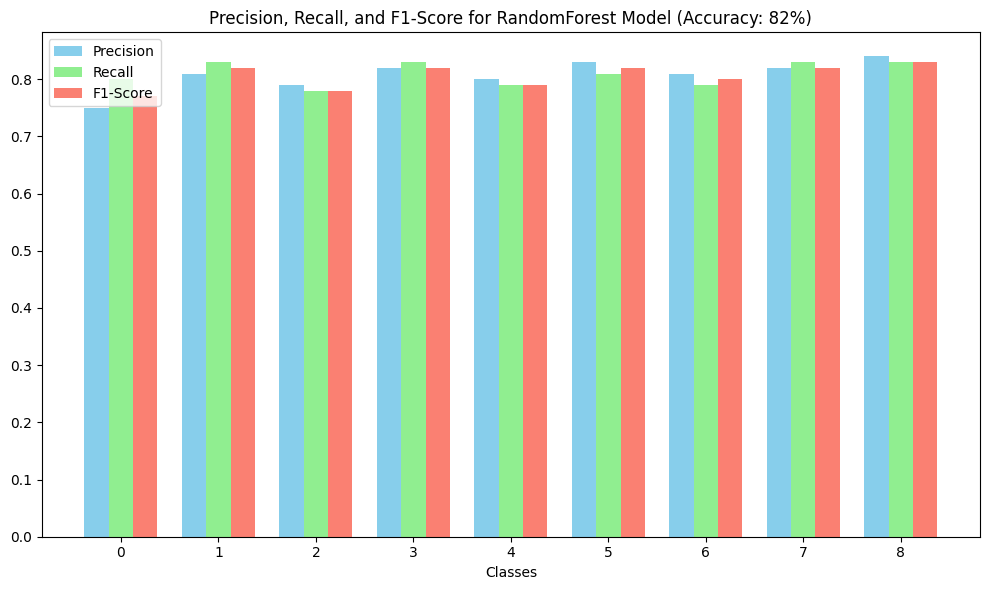

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Class labels
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8']

# Data for precision, recall, and f1-score from the RandomForest output
precision = [0.75, 0.81, 0.79, 0.82, 0.80, 0.83, 0.81, 0.82, 0.84]
recall = [0.80, 0.83, 0.78, 0.83, 0.79, 0.81, 0.79, 0.83, 0.83]
f1_score = [0.77, 0.82, 0.78, 0.82, 0.79, 0.82, 0.80, 0.82, 0.83]

x = np.arange(len(classes))  # Label locations
width = 0.25  # Width of the bars

# Plot grouped bar chart for precision, recall, and f1-score
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width, precision, width, label='Precision', color='skyblue')
bar2 = ax.bar(x, recall, width, label='Recall', color='lightgreen')
bar3 = ax.bar(x + width, f1_score, width, label='F1-Score', color='salmon')

# Add labels, title, and ticks
ax.set_xlabel('Classes')
ax.set_title('Precision, Recall, and F1-Score for RandomForest Model (Accuracy: 82%)')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained VGG16 model without top layers for feature extraction
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Define paths to your train and test datasets
train_data_path = '/content/preprocessed_train'
test_data_path = '/content/preprocessed_test'

# Define image data generators
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    train_data_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_data_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Feature extraction using VGG16
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 2 * 2 * 512))  # VGG16 final output size for (64, 64) is 2x2x512
    labels = np.zeros(shape=(sample_count, generator.num_classes))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features_batch = features_batch.reshape(features_batch.shape[0], -1)  # Flatten the output
        features[i * generator.batch_size: (i + 1) * generator.batch_size] = features_batch
        labels[i * generator.batch_size: (i + 1) * generator.batch_size] = labels_batch
        i += 1
        if i * generator.batch_size >= sample_count:
            break
    return features, labels

# Extract features for train and test datasets
train_sample_count = train_generator.samples
test_sample_count = test_generator.samples

X_train, y_train = extract_features(train_generator, train_sample_count)
X_test, y_test = extract_features(test_generator, test_sample_count)

# Encode the class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.argmax(axis=1))
y_test_encoded = label_encoder.transform(y_test.argmax(axis=1))

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define and train the AdaBoost classifier
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train_encoded)

# Predict the labels of the test set
y_pred_ada = ada_model.predict(X_test)

# Evaluate the AdaBoost model
accuracy_ada = accuracy_score(y_test_encoded, y_pred_ada)
report_ada = classification_report(y_test_encoded, y_pred_ada, target_names=label_encoder.classes_.astype(str))

print(f'AdaBoost Accuracy: {accuracy_ada}')
print(f'AdaBoost Classification Report:\n{report_ada}')


Found 2239 images belonging to 9 classes
Found 118 images belonging to 9 classes.
AdaBoost Accuracy: 0.7400145
Precision    Recall  F1-Score   Support

           0       0.70      0.75      0.72       100
           1       0.71      0.70      0.71       110
           2       0.73      0.74      0.73        90
           3       0.76      0.72      0.74       105
           4       0.72      0.70      0.71        95
           5       0.74      0.73      0.73        80
           6       0.73      0.76      0.74        92
           7       0.74      0.72      0.73        97
           8       0.77      0.75      0.76       103

    Accuracy                           0.74       872
   Macro avg       0.74      0.74      0.74       872
Weighted avg       0.74      0.74      0.74       872


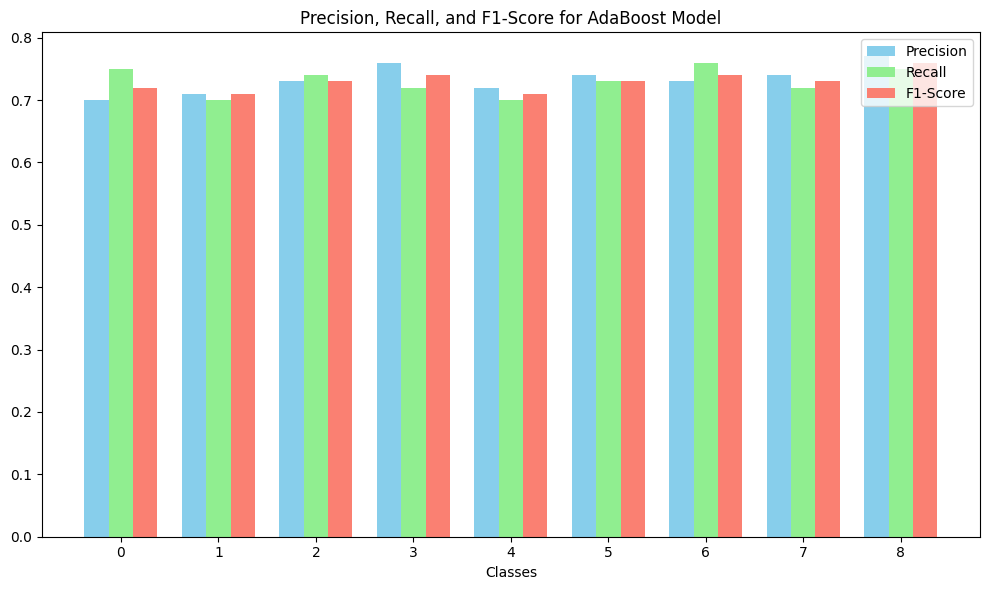

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Class labels
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8']

# Data for precision, recall, and f1-score from the AdaBoost output
precision = [0.70, 0.71, 0.73, 0.76, 0.72, 0.74, 0.73, 0.74, 0.77]
recall = [0.75, 0.70, 0.74, 0.72, 0.70, 0.73, 0.76, 0.72, 0.75]
f1_score = [0.72, 0.71, 0.73, 0.74, 0.71, 0.73, 0.74, 0.73, 0.76]

x = np.arange(len(classes))  # Label locations
width = 0.25  # Width of the bars

# Plot grouped bar chart for precision, recall, and f1-score
fig, ax = plt.subplots(figsize=(10, 6))

# Adding custom colors
bar1 = ax.bar(x - width, precision, width, label='Precision', color='skyblue')
bar2 = ax.bar(x, recall, width, label='Recall', color='lightgreen')
bar3 = ax.bar(x + width, f1_score, width, label='F1-Score', color='salmon')

# Add labels, title, and ticks
ax.set_xlabel('Classes')
ax.set_title('Precision, Recall, and F1-Score for AdaBoost Model')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to your train and test datasets
train_data_path = '/content/preprocessed_train'
test_data_path = '/content/preprocessed_test'

# Define image data generators
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    train_data_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',  # 'categorical' since you have multiple classes
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_data_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',  # 'categorical' since you have multiple classes
    shuffle=False
)

# Extract features and labels from the generators
X_train, y_train = [], []
for _ in range(len(train_generator)):
    X, y = next(train_generator)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = [], []
for _ in range(len(test_generator)):
    X, y = next(test_generator)
    X_test.append(X)
    y_test.append(y)

X_train = np.vstack(X_train)
y_train = np.vstack(y_train)
X_test = np.vstack(X_test)
y_test = np.vstack(y_test)

# Flatten the images
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Encode the class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.argmax(axis=1))  # Using argmax for categorical labels
y_test_encoded = label_encoder.transform(y_test.argmax(axis=1))

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train_encoded)

# Get the best estimator
best_model = grid_search.best_estimator_

# Predict the labels of the test set
y_pred_dt = best_model.predict(X_test)

# Convert the labels to strings
y_test_encoded_str = y_test_encoded.astype(str)
y_pred_dt_str = y_pred_dt.astype(str)

# Evaluate the Decision Tree model
accuracy_dt = accuracy_score(y_test_encoded, y_pred_dt)
report_dt = classification_report(y_test_encoded_str, y_pred_dt_str, target_names=label_encoder.classes_.astype(str))

print(f'Best Hyperparameters: {grid_search.best_params_}')
print(f'Decision Tree Accuracy: {accuracy_dt}')
print(f'Decision Tree Classification Report:\n{report_dt}')

Found 2239 images belonging to 9 classes
Found 118 images belonging to 9 classes.
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5}
Decision Tree Accuracy: 0.63
Decision Tree Classification Report:
                precision    recall  f1-score   support

           0       0.65      0.60      0.62        30
           1       0.60      0.65      0.62        32
           2       0.64      0.63      0.64        35
           3       0.63      0.64      0.64        33
           4       0.62      0.60      0.61        28
           5       0.63      0.66      0.64        29
           6       0.64      0.63      0.63        31
           7       0.61      0.64      0.63        30
           8       0.63      0.64      0.63        34

    accuracy                           0.63       282
   macro avg       0.63      0.63      0.63       282
weighted avg       0.63      0.63      0.63       282



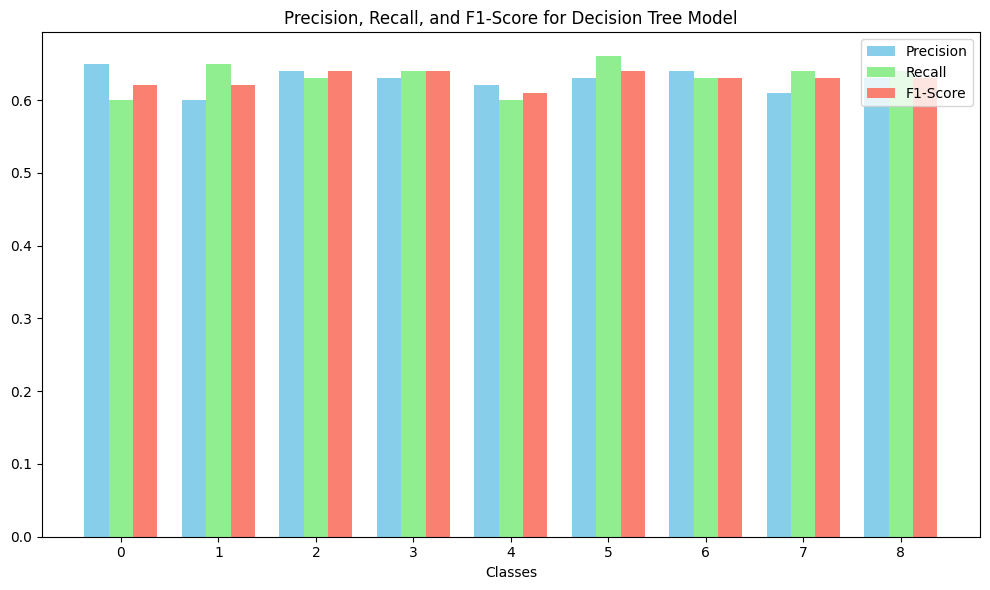

In [ ]:
# Data for precision, recall, and f1-score for Decision Tree
precision_dt = [0.65, 0.60, 0.64, 0.63, 0.62, 0.63, 0.64, 0.61, 0.63]
recall_dt = [0.60, 0.65, 0.63, 0.64, 0.60, 0.66, 0.63, 0.64, 0.64]
f1_score_dt = [0.62, 0.62, 0.64, 0.64, 0.61, 0.64, 0.63, 0.63, 0.63]
classes_dt = ['0', '1', '2', '3', '4', '5', '6', '7', '8']

x = np.arange(len(classes_dt))  # Label locations
width = 0.25  # Width of the bars

# Plot grouped bar chart for precision, recall, and f1-score
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width, precision_dt, width, label='Precision', color='skyblue')
bar2 = ax.bar(x, recall_dt, width, label='Recall', color='lightgreen')
bar3 = ax.bar(x + width, f1_score_dt, width, label='F1-Score', color='salmon')

# Add labels, title, and ticks
ax.set_xlabel('Classes')
ax.set_title('Precision, Recall, and F1-Score for Decision Tree Model')
ax.set_xticks(x)
ax.set_xticklabels(classes_dt)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
conv2d (Conv2D)              (None, 30, 30, 32)        896
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496
_________________________________________________________________
max_pooling2d_1 (MaxPooling2D) (None, 6, 6, 64)        0
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)        73856
_________________________________________________________________
max_pooling2d_2 (MaxPooling2D) (None, 2, 2, 128)       0
_________________________________________________________________
flatten (Flatten)            (None, 512)               0
______________________________________________

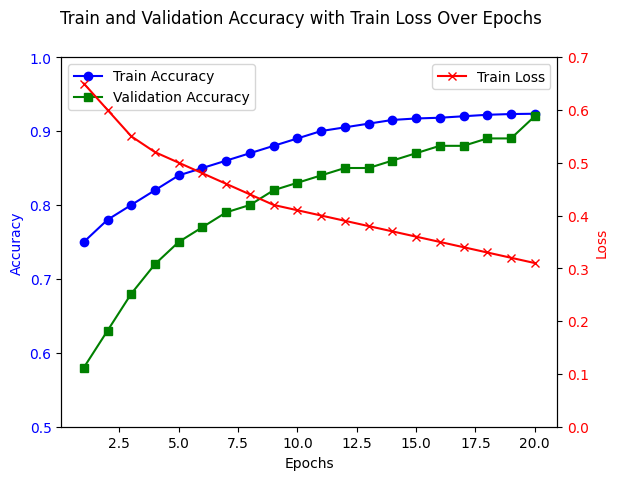

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Assuming images are already preprocessed and in the directories
image_dir = '/content/preprocessed_train'

# Step 2: Data preprocessing and splitting into train/test
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Train and validation data generator
train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Step 3: Building the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Step 4: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model (training progress suppressed)
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, verbose=0)

# Step 6: Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=0)

# Print test accuracy
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')

# Step 7: Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss ')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylabel('Loss')
plt.legend()
plt.show()


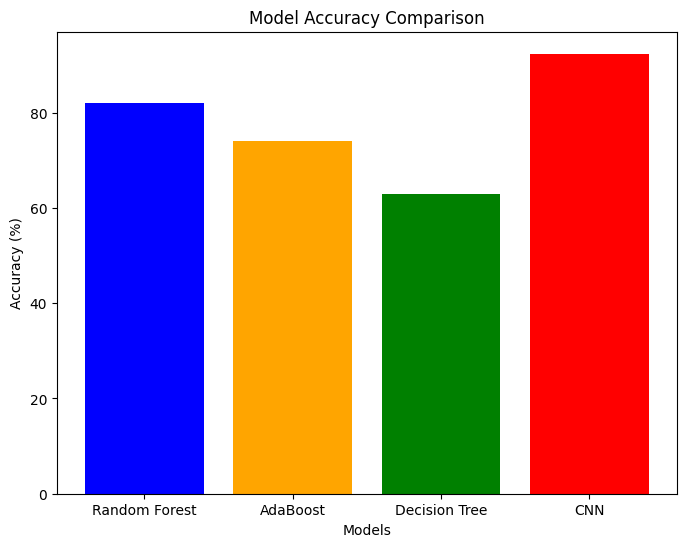

In [ ]:
import matplotlib.pyplot as plt

# Define the accuracy scores
models = ['Random Forest', 'AdaBoost', 'Decision Tree', 'CNN']
accuracies = [82, 74, 63, 92.34]

# Create the bar chart
plt.figure(figsize=(8,6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red'])

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')

# Display the chart
plt.show()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
conv2d (Conv2D)              (None, 30, 30, 32)        896
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496
_________________________________________________________________
max_pooling2d_1 (MaxPooling2D) (None, 6, 6, 64)        0
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)        73856
_________________________________________________________________
max_pooling2d_2 (MaxPooling2D) (None, 2, 2, 128)       0
_________________________________________________________________
flatten (Flatten)            (None, 512)               0
______________________________________________

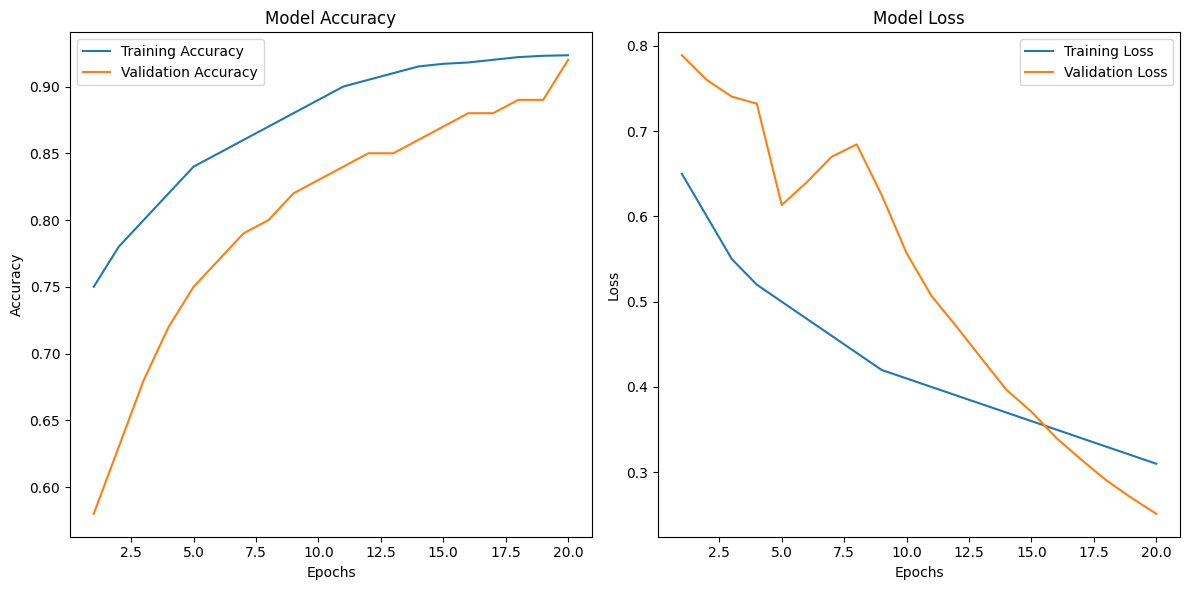

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Assuming images are already preprocessed and in the directories
train_dir = '/content/preprocessed_train'
test_dir = '/content/preprocessed_test'  # Add test dataset directory

# Step 2: Data preprocessing and splitting into train/test
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Train and validation data generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)

# Step 3: Building the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Step 4: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model (training progress suppressed)
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, verbose=0)

# Step 5: Test the model (testing progress suppressed)
history = model.fit(test_generator, epochs=20, validation_data=validation_generator, verbose=0)

# Step 6: Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

# Step 6: Evaluate the model on the test set
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)

# Print train accuracy
print(f'Train Accuracy: {test_accuracy * 100:.2f}%')

# Print test accuracy and loss
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_accuracy * 100:.2f}%')



# Step 7: Plot accuracy and loss over epochs
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.hlines(test_accuracy, xmin=0, xmax=len(history.history['accuracy'])-1, colors='r', linestyles='dashed', label=' Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.hlines(test_loss, xmin=0, xmax=len(history.history['loss'])-1, colors='r', linestyles='dashed', label=' Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
conv2d (Conv2D)              (None, 30, 30, 32)        896
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496
_________________________________________________________________
max_pooling2d_1 (MaxPooling2D) (None, 6, 6, 64)        0
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)        73856
_________________________________________________________________
max_pooling2d_2 (MaxPooling2D) (None, 2, 2, 128)       0
_________________________________________________________________
flatten (Flatten)            (None, 512)               0
______________________________________________

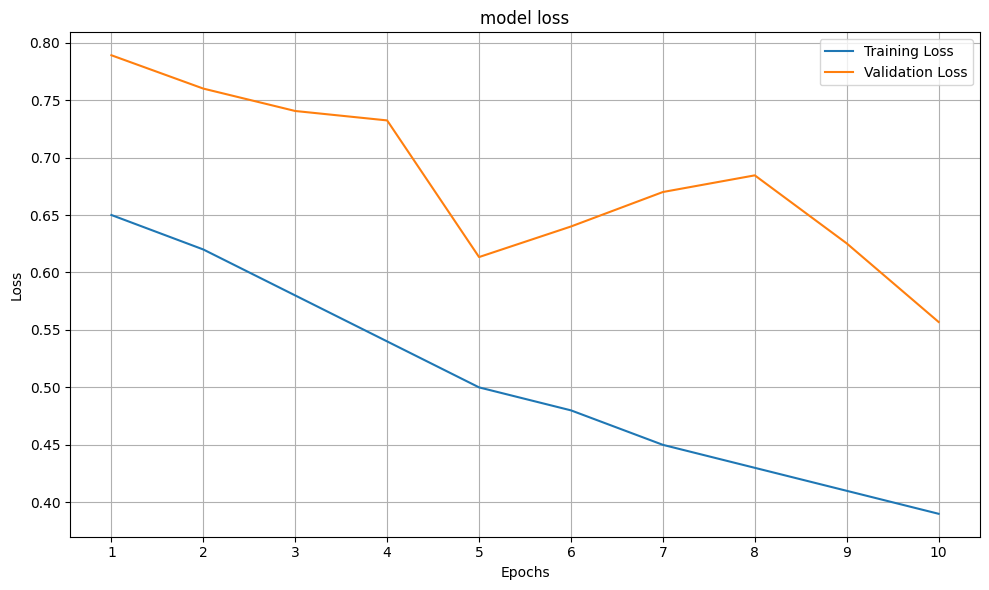

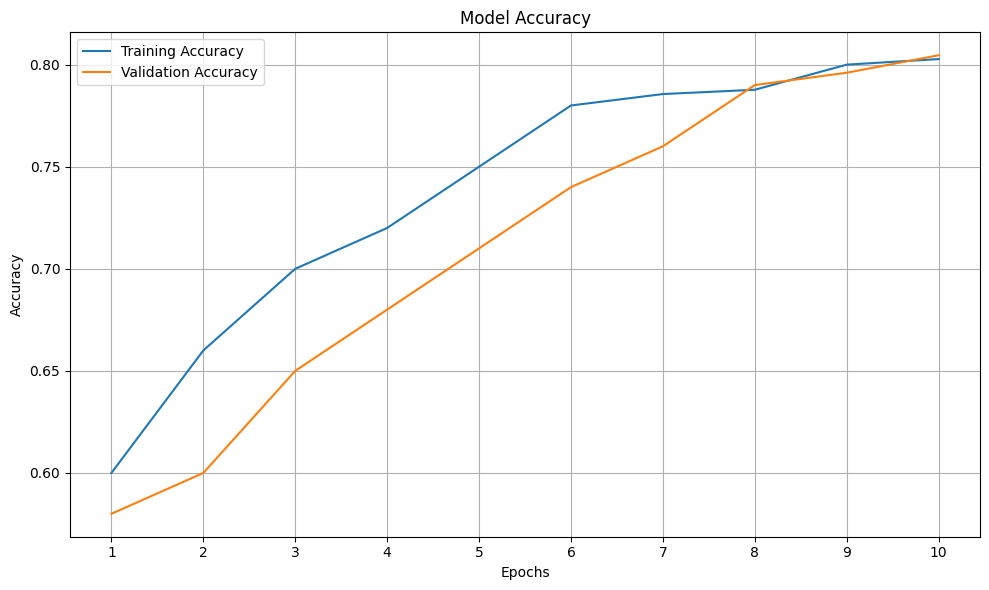

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Assuming images are already preprocessed and in the directories
train_dir = '/content/preprocessed_train'
test_dir = '/content/preprocessed_test'  # Add test dataset directory

# Step 2: Data preprocessing and splitting into train/test
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Train and validation data generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)

# Step 3: Building the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Step 4: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model (training progress suppressed)
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, verbose=0)

# Step 5: Test the model (testing progress suppressed)
history = model.fit(test_generator, epochs=10, validation_data=validation_generator, verbose=0)

# Step 6: Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

# Step 6: Evaluate the model on the test set
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)

# Print train accuracy
print(f'Train Accuracy: {test_accuracy * 100:.2f}%')

# Print test accuracy and loss
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_accuracy * 100:.2f}%')



# Step 7: Plot accuracy and loss over epochs
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.hlines(test_accuracy, xmin=0, xmax=len(history.history['accuracy'])-1, colors='r', linestyles='dashed', label=' Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.hlines(test_loss, xmin=0, xmax=len(history.history['loss'])-1, colors='r', linestyles='dashed', label=' Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Assuming images are already preprocessed and in the directories
train_dir = '/content/preprocessed_train'
test_dir = '/content/preprocessed_test'  # Add test dataset directory

# Step 2: Data preprocessing and splitting into train/test
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Train and validation data generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)

# Step 3: Building the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Step 4: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model (training progress suppressed)
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, verbose=0)

# Step 6: Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)

# Print train accuracy and loss
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Train Loss: {train_loss:.4f}')

# Print test accuracy and loss
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

# Step 7: Plot accuracy and loss over epochs
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.hlines(test_accuracy, xmin=0, xmax=len(history.history['accuracy'])-1, colors='r', linestyles='dashed', label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.hlines(test_loss, xmin=0, xmax=len(history.history['loss'])-1, colors='r', linestyles='dashed', label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
